In this notebook an Autoencoder is designed to optimize performance of PAM transiver over ASE + Thermal

Channel:\
$\sigma = 10^(-SNR_{totoal}/20)$\
$TX → AWGN_{\sqrt{(1-\alpha)\sigma}} → PD → AWGN_{\alpha\sigma}$

Best parameters sofar:

Optimizer: Adam

Learning rate: 0.001

activation: ReLU

Layers: (256, )

Itterations: 3000

# Functions

In [ ]:
from weakref import ref
import numpy as np
import torch

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torchvision import transforms
from torch.nn.modules.distance import PairwiseDistance
from copy import copy
import matplotlib.pyplot as plt

from datetime import time, date, datetime
import time
import pickle
import random
import sys
import itertools

import math
import matplotlib
from matplotlib.colors import ListedColormap

from mpl_toolkits.axisartist.axislines import SubplotZero
import warnings
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

import scipy
import scipy.io as io 
import copy

from mpl_toolkits.axisartist.axislines import SubplotZero
from scipy.integrate import quad
from scipy.stats import norm
from scipy.interpolate import interp1d
from sympy.combinatorics.graycode import GrayCode
import pickle as pkl
import os

from IPython import display
from pathlib import Path
from IPython.core.pylabtools import figsize
from numpy.core.fromnumeric import size

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def binary_batch_to_decimal(Targets):
    """
    This Function Takes a Matrix of the size N * S
    - N number of symbols
    - S Symbol size (#Bits of each symbol )
    and returns a tensor of integers 
    Example: 
    Targets: [[0, 1, 1, 0, 0, 1],
              [1, 0, 1, 1, 0, 1],
              [1, 1, 1, 0, 1, 1]]
    int_Targets: [3, 5, 2, 1, 7]
    """
    int_Targets = np.zeros([len(Targets[:,0])])    
    for j in range(len(Targets[:,0])):
        x=0
        l=len(Targets[0,:])
        for i in range(l):
                x+=Targets[j,i]*2**(l-1-i) 
        int_Targets[j]=x
    return int_Targets.reshape(-1,1)

def messages_to_onehot(intMessages,M):
    """
    Convert messages represented as indexes to one-hot encoding.

    :param messages: List of messages to convert.
    :param order: Number of possible messages.
    :return: One-hot encoded messages.

    Example: messages_to_onehot(torch.tensor([0, 2, 0, 3, 4])) =>>
    torch.tensor([
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],

        [0., 0., 0., 0., 1.],
    ])
    """
    return torch.nn.functional.one_hot(intMessages, num_classes=M).float()

def tx_PAM_Gen(trP, tp): 
  '''
  This fuction generates PAM symbols based on the PAM order
  input: 
    syst: attribute dictionary of system parameters 
  output:    
    Tx_sym: the index of the symbols (any of [0,1,2,...,M]) where M is the PAM order
    Tx_coords: coordinates for Tx_sym
  '''   
  if tp =='train': 
    bs = trP.batchSize
  else: 
    bs = trP.TSTbatchSize
  ###############################################
  # geterate random symbols with the size (N,1)
  Tx_syms = torch.randint(0,trP.M,(bs,))

  ###############################################
  # get PAM reference coordinates
  onehotTx = messages_to_onehot(Tx_syms,trP.M)  
  
  ###############################################
  # assign the intensities to the symbols 

  return Tx_syms, onehotTx

def get_SER_BER_MC(model, trP):
    """
    This function receives a constellation and a calculates
    Monte-Carlo BER 
    """
    
    
    ######################################################################
    # Initialization
    ######################################################################    
    bit_errors = 0
    bit_stream_size = 0
    N_symbols = 0
    sym_error_count = 0
    
    while sym_error_count < 100:
      ###      
      ######################################################################
      # Create Random data and convert it to one-hot
      ######################################################################
      classes_Tx, onehotTx = tx_PAM_Gen(trP,'test')  

  
      N_symbols += torch.max(torch.tensor(classes_Tx.shape))
      # print('n s: ', N_symbols)
      ######################################################################
      # Apply random data to the model
      ######################################################################
      model.eval()
      with torch.no_grad():        
        scores, encOutNorm, channelOut  = model(onehotTx)

        # print('\nscores: ',scores.shape)

        m = nn.Softmax(dim=1)
        probabilities = m(scores)
        # print('\nprobabilities: ',probabilities.shape)
      

        intRx = []
        # predictions = torch.zeros([len(probabilities), len(probabilities[0])], dtype=torch.float)       
        
        for i in range (len(probabilities)):  
          maximum_val, idx = torch.max(probabilities[i],dim=0)
          # predictions[i][idx]=1
          intRx.append(idx)
            

  
        # intRx = torch.tensor([torch.where(r==1)[0][0] for r in predictions])
        
        intRx = torch.stack(intRx)        
        # print('\nRX: ',intRx[:10])
        # for i in range(len(intRx)): 
        #     if Tx[i] != intRx[i]:
        #         sym_error_count += 1
        # print(sym_error_count)
        # sys.exit()
        
        sym_error_count+=torch.sum(classes_Tx != intRx)
        # print('EEERRROOOORSSSS: ',sym_error_count)
    SER = sym_error_count/N_symbols  
  
    return SER


# Autoencoder model

In [ ]:
############################################################
## Class of Parameters
class ConstellationNet(nn.Module):
    """
    This Class creates an Autoencoder srtucture which is used to 
    train an End-to-End communication system.
    """
    def __init__(self, syst=AttrDict(), trP=AttrDict()):
        """
        Create an Autoencoder.

        :param order: Order of the constellation, i.e. the number of 
        messages that are to be transmitted, or equivalently the number
        of symbols whose placements in the constellation have to be 
        learned.

        :param encoder_layers: Shape of the encoder’s hidden layers. 
        The size of this sequence is the number of hidden layers, with
        each element being a number which specifies the number of 
        neurons in its channel.

        :param decoder_layers: Shape of the decoder’s hidden layers. 
        Uses the same convention as `encoder_layers_sizes` above.
        """
        super(ConstellationNet, self).__init__()
        self.syst = syst
     
        self.trP = trP

        self.encoder_layers = self.trP.layers
        self.decoder_layers = self.encoder_layers[::-1]


        self.prev_layer_size = self.trP.M
        self.encoder_layers_list = []

        for self.layer_size in self.encoder_layers:
            self.encoder_layers_list.append(nn.Linear(self.prev_layer_size, self.layer_size,bias=True))            
            self.encoder_layers_list.append(trP.activation)
            self.encoder_layers_list.append(nn.BatchNorm1d(self.layer_size))  
                      
            
            self.prev_layer_size = self.layer_size

        self.encoder_layers_list += [nn.Linear(self.prev_layer_size, 1), ]

        self.encoder = nn.Sequential(*self.encoder_layers_list)
        #########################################################################
        # Build the decoder network taking the noisy I/Q vector received from
        # the channel as input and outputting a probability vector for each
        # original message. The network additionally uses hidden layers as
        # specified in `decoder_layers`
        #########################################################################
        self.prev_layer_size = 1
        self.decoder_layers_list = []

        for self.layer_size in self.decoder_layers:
            self.decoder_layers_list.append(nn.Linear(self.prev_layer_size, self.layer_size,bias=True))
            self.decoder_layers_list.append(trP.activation)
            self.decoder_layers_list.append(nn.BatchNorm1d(self.layer_size))
            self.decoder_layers_list.append(nn.Linear(self.layer_size, self.layer_size,bias=False))
            self.decoder_layers_list.append(trP.activation)
            self.decoder_layers_list.append(nn.BatchNorm1d(self.layer_size))

                     
            self.prev_layer_size = self.layer_size
           
        self.decoder_layers_list.append(nn.Linear(self.prev_layer_size, trP.M))    
  
        self.decoder = nn.Sequential(*self.decoder_layers_list)



        # for param in self.encoder.parameters():
        #     param.requires_grad = True
        # self.hSize = 256
        # ##############################################################
        # ## Encoder
        # self.efc1 = nn.Linear(self.trP.M*self.trP.seq_len, self.hSize, bias=True)
        # self.ebn1 = nn.BatchNorm1d(self.hSize)
        # self.efc2 = nn.Linear(self.hSize,1)

        # ##############################################################
        # ## Decoder
        # self.dfc1 = nn.Linear(1*self.trP.seq_len, self.hSize, bias=True)
        # self.dbn1 = nn.BatchNorm1d(self.hSize)
        # self.dfc2 = nn.Linear(self.hSize,self.trP.M)

    def normalize_power_real(self, x):
        """
        Normalization if constellation received in x is acomplished here.
        """ 
        epsilon = 1e-12        
        average_power = torch.mean(torch.abs(x)**2)
        average_power = torch.max(torch.tensor([epsilon, average_power]))            
        normF = torch.rsqrt(average_power)
        x = x * normF       
        return  x

    def add_transmitter_noise(self, signal, P_sig_before_PD, P_sig_after_PD):
      epsilon = 1e-20
      noise = (torch.randn(torch.max(torch.tensor(signal.shape)))).reshape(-1,1)
      ASE_var=(1-self.syst.alpha)*(10**(-self.syst.SNR_total/10))*P_sig_after_PD
      var_n1 = ((-6*P_sig_before_PD)+torch.sqrt((36*P_sig_before_PD**2)+12*ASE_var))/6
      var_n1 =  torch.max(torch.tensor([epsilon, var_n1]))  
      Data_out_ASE = signal+torch.sqrt(var_n1)*noise;
      return Data_out_ASE
        
    def add_thermal_noise(self, signal, P_sig_before_PD, P_sig_after_PD):
      noise = (torch.randn(np.max(signal.shape))).reshape(-1,1)
      Thermal_var=(self.syst.alpha)*(10**(-self.syst.SNR_total/10))*P_sig_after_PD
      Data_out=signal+torch.sqrt(Thermal_var)*noise
      return Data_out      

    def get_constellation(self, ): 
      '''this function is written for when a sequence size of 1 is used'''
      with torch.no_grad():
            ######################################################################
            # List of training examples in form of tensor 
            # of integers (not shuffled) with size = order
            ######################################################################
            # classes_ordered = torch.arange(order)
            enc = self.encoder(messages_to_onehot(
                    torch.arange(0, self.trP.M),
                    self.trP.M))    
            constellation = self.normalize_power_real(torch.abs(enc))         
      return constellation

    def getEuclideanScores(self, x):
      x = x.reshape(1,-1)      
      cnt_amp = (torch.squeeze(self.get_constellation(), 1))**2
      # print('cnt_amp',cnt_amp.shape)
      # print('cnt_amp',cnt_amp)
      
      # print('x',x.shape)
      # print('x',x[0,-3:])


      d = torch.zeros((x.shape[1],len(cnt_amp)))

      for i in range(len(cnt_amp)):
        d[:,i] = torch.abs(x[0,:]-cnt_amp[i])+1
      d = 1/d**2 #torch.sqrt(d)
     
      # scores=[]
      # for i in range(x.shape[1]):
      #   tmp = (torch.abs(x[0,i]-cnt_amp))
      #   scores.append(tmp)
      # d = torch.stack(scores)     
      # print('d',d.shape)
      # print('d',d[-3:,:])
      # sys.exit()             
      # scores = torch.exp((-d**2)) / torch.sum(torch.exp(-d**2))
      return d

    def forward(self, x):
        """
        Performs encoding and decoding of an input vector and compute its
        reconstructed vector.

        :param x: Original one-hot encoded data.
        
        :return: Reconstructed vector. This Vector Containd Scores of be ing '1' or '0'
        """      
        # print('x',x)
        # Encoder
        symbols = self.encoder(x)     
        # print('symbols',symbols)        
        normalizedSymbols = self.normalize_power_real(torch.abs(symbols))

        # print('normalizedSymbols',normalizedSymbols)
        P_sig_before_PD=torch.mean(torch.abs(normalizedSymbols)**2)
        P_sig_after_PD=torch.mean(torch.abs(normalizedSymbols)**4)
        # channel  
        noisy_x = self.add_transmitter_noise(normalizedSymbols, P_sig_before_PD, P_sig_after_PD)
        # print('noisy_x1',noisy_x)
        noisy_x = torch.abs(noisy_x)**2
        # print('noisy_x2',noisy_x)
        noisy_x = self.add_thermal_noise(noisy_x, P_sig_before_PD, P_sig_after_PD)
        
        # print('noisy_x3',noisy_x)
        # dc = self.getEuclideanScores(noisy_x)
        dc = self.decoder(noisy_x)
        # print('dec',dc)
        

        return dc, normalizedSymbols, noisy_x 


#Train


		 ---- Training Started!!! ----

	 SNR: 26

	 Itteration number: 0
	 Current Loss is: 2.1060097217559814
	 Current SER is: 0.875195324420929
	 Best SER is: 0.875195324420929

	 Best constellatiuon is: tensor([[0.7612, 1.7676, 0.1497, 0.7776, 0.8038, 0.5688, 0.8886, 1.3820]])


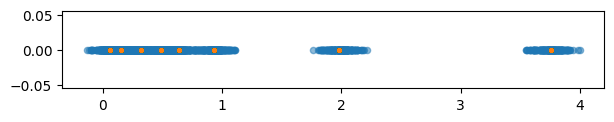

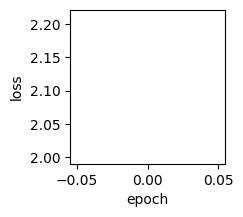


	 SNR: 26

	 Itteration number: 1000
	 Current Loss is: 0.042399030178785324
	 Current SER is: 0.02802734449505806
	 Best SER is: 0.01171875

	 Best constellatiuon is: tensor([[0.0601, 0.7289, 1.4691, 1.1839, 1.3222, 1.0435, 0.8965, 0.5143]])


<Figure size 700x100 with 0 Axes>

<Figure size 700x100 with 0 Axes>

<Figure size 700x100 with 0 Axes>

<Figure size 700x100 with 0 Axes>

<Figure size 700x100 with 0 Axes>

<Figure size 700x100 with 0 Axes>

<Figure size 700x100 with 0 Axes>

<Figure size 700x100 with 0 Axes>

<Figure size 700x100 with 0 Axes>

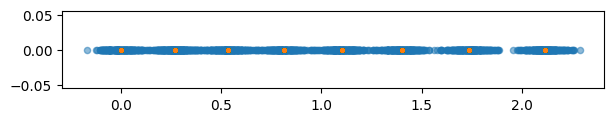

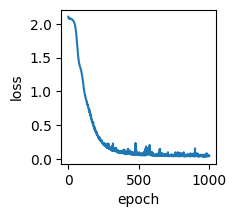

Epoch 01168: reducing learning rate of group 0 to 1.2500e-03.
Epoch 01319: reducing learning rate of group 0 to 3.1250e-04.
Epoch 01560: reducing learning rate of group 0 to 7.8125e-05.
Epoch 01711: reducing learning rate of group 0 to 1.9531e-05.
Epoch 01862: reducing learning rate of group 0 to 4.8828e-06.

	 SNR: 26

	 Itteration number: 2000
	 Current Loss is: 0.030357593670487404
	 Current SER is: 0.01357421837747097
	 Best SER is: 0.01113281212747097

	 Best constellatiuon is: tensor([[0.0252, 0.7283, 1.4645, 1.1863, 1.3226, 1.0476, 0.8984, 0.5128]])


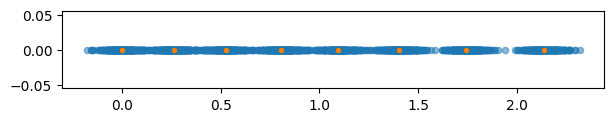

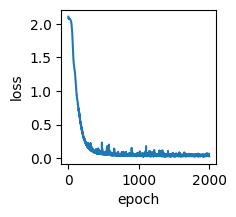

Epoch 02013: reducing learning rate of group 0 to 1.2207e-06.
Epoch 02164: reducing learning rate of group 0 to 3.0518e-07.
Epoch 02315: reducing learning rate of group 0 to 7.6294e-08.
Epoch 02466: reducing learning rate of group 0 to 1.9073e-08.
Epoch 02617: reducing learning rate of group 0 to 4.7684e-09.

	 SNR: 26

	 Itteration number: 3000
	 Current Loss is: 0.035435378551483154
	 Current SER is: 0.010937499813735485
	 Best SER is: 0.00986328162252903

	 Best constellatiuon is: tensor([[0.0253, 0.7282, 1.4643, 1.1865, 1.3226, 1.0476, 0.8985, 0.5129]])


<Figure size 700x100 with 0 Axes>

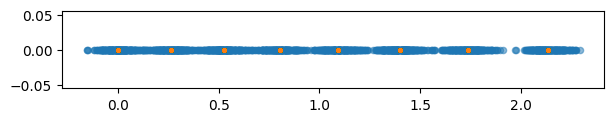

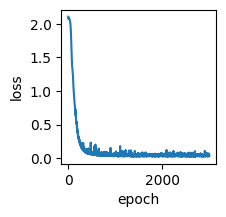


	 SNR: 26

	 Itteration number: 4000
	 Current Loss is: 0.05303630605340004
	 Current SER is: 0.01230468787252903
	 Best SER is: 0.00986328162252903

	 Best constellatiuon is: tensor([[0.0253, 0.7282, 1.4643, 1.1865, 1.3226, 1.0476, 0.8985, 0.5129]])


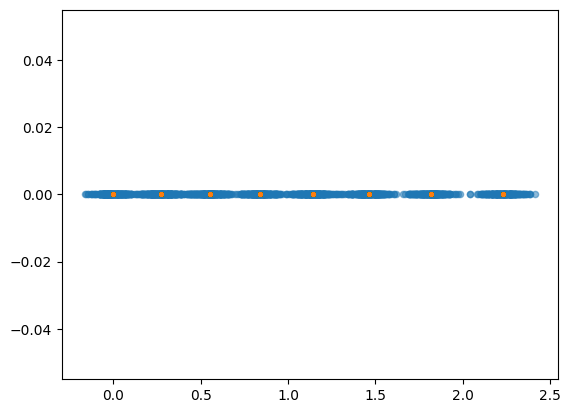

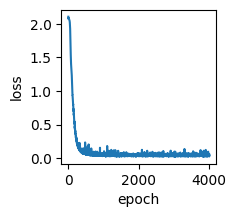


	 SNR: 26

	 Itteration number: 5000
	 Current Loss is: 0.06963681429624557
	 Current SER is: 0.01220703125
	 Best SER is: 0.00986328162252903

	 Best constellatiuon is: tensor([[0.0253, 0.7282, 1.4643, 1.1865, 1.3226, 1.0476, 0.8985, 0.5129]])


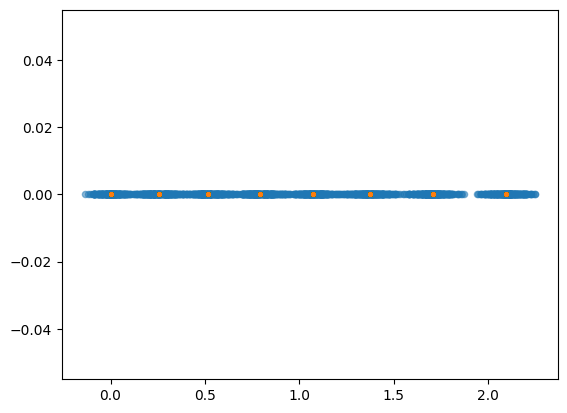

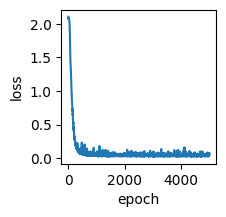


	 SNR: 26

	 Itteration number: 6000
	 Current Loss is: 0.040176957845687866
	 Current SER is: 0.012402343563735485
	 Best SER is: 0.00986328162252903

	 Best constellatiuon is: tensor([[0.0253, 0.7282, 1.4643, 1.1865, 1.3226, 1.0476, 0.8985, 0.5129]])


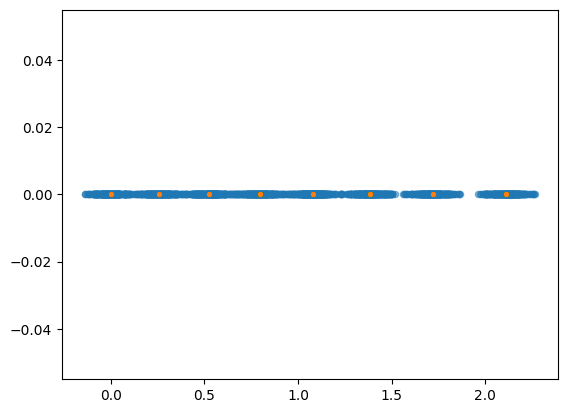

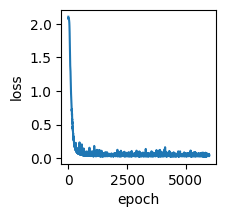


	 SNR: 26

	 Itteration number: 7000
	 Current Loss is: 0.05143570527434349
	 Current SER is: 0.01328125037252903
	 Best SER is: 0.00986328162252903

	 Best constellatiuon is: tensor([[0.0253, 0.7282, 1.4643, 1.1865, 1.3226, 1.0476, 0.8985, 0.5129]])


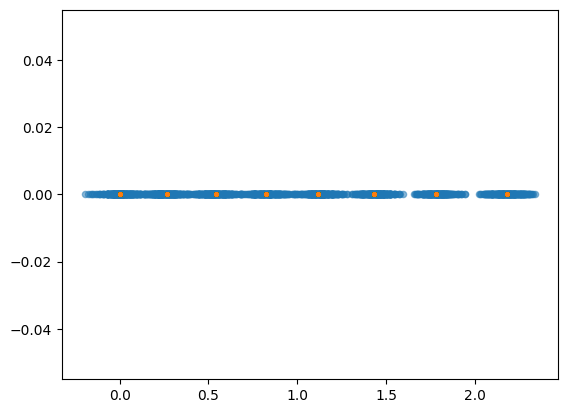

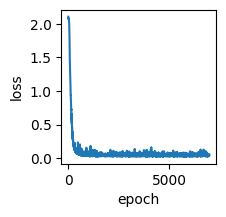


	 SNR: 26

	 Itteration number: 8000
	 Current Loss is: 0.04532518610358238
	 Current SER is: 0.01181640662252903
	 Best SER is: 0.00986328162252903

	 Best constellatiuon is: tensor([[0.0253, 0.7282, 1.4643, 1.1865, 1.3226, 1.0476, 0.8985, 0.5129]])


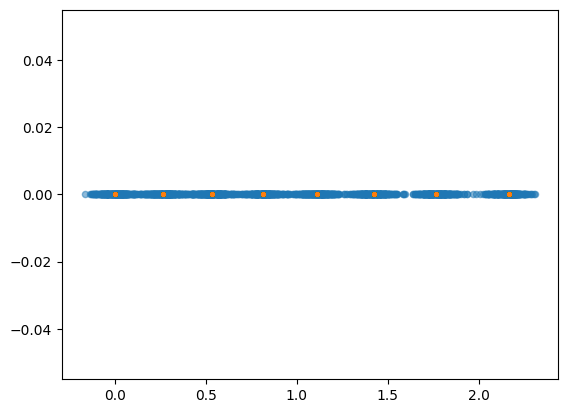

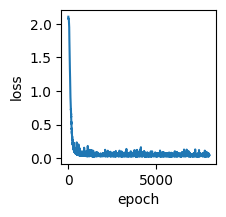



			Training is done


########### Final Best Results #########################
****** Bests are ******
**** Best SER:  tensor(0.0099)
**** Best constellation:  tensor([[0.0253, 0.7282, 1.4643, 1.1865, 1.3226, 1.0476, 0.8985, 0.5129]])
SER is:  tensor([0.0099])


In [20]:
torch.set_printoptions(threshold=10_000)
def train(syst, trP):#, EncModel, DecModel):
   
  print('\t\t ---- Training Started!!! ----')
  
  ##############################################################
  ## Get an instance of model
  model = ConstellationNet(syst, trP)
  
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=trP.learningRate)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
      optimizer, 
      verbose=True, #  If True, prints a message to stdout for each update. Default: False.
      factor=0.25, # Factor by which the learning rate will be reduced. new_lr = lr * factor. Default: 0.1.
      patience=100, # Number of epochs with no improvement after which learning rate will be reduced. 
      cooldown=50, # Number of epochs to wait before resuming normal operation after lr has been reduced. Default: 0.
      threshold=1e-8 # Threshold for measuring the new optimum, to only focus on significant changes. Default: 1e-4.
  )
  ##############################################################
  i = 0
  losses = []
  best_cnt = torch.tensor([[0],[1],[2],[3],[4],[5],[6],[7]])
  best_ser = float('inf')
  while i <= trP.itrs:                
    ## PAM level generation (1-sps)
    layer_names = []
    # for idx, (name, param) in enumerate(model.named_parameters()):
    #   # layer_names.append(name)
    #    print(f"{name}: requires_grad={param.grad}")

    
    
    classes_Tx, onehotTx = tx_PAM_Gen(trP,'train')  
    onehotTx.requires_grad = True
    # print('------------------',onehotTx.requires_grad)

    model.train()   
    model.eval()
    optimizer.zero_grad()    
    predictions, normalizedSymbols, noisy_x = model(onehotTx)       
    
    loss = criterion(predictions, classes_Tx)  
    losses.append(loss.detach().numpy())

    loss.backward()        
    optimizer.step()
    scheduler.step(loss) ### Does the Update
    
    # print(model.encoder[0].weight.grad)
    # print(model.encoder[0].weight)
    # print(model.encoder[0].weight.requires_grad)
      
    # from torchviz import make_dot
    # make_dot(predictions, params=dict(model.named_parameters())).render("my_model.gv", format="png")

    # for name, param in model.named_parameters():
    #     print(f"{name}: requires_grad={param.grad}")
    if i%(50)== 0:
      ser = get_SER_BER_MC(model, trP)     
      cnt = model.get_constellation()
      if ser < best_ser: 
        best_ser = ser   
        best_cnt = cnt
        plt.figure(figsize=(7,1),dpi=100)
      if i%(1000)== 0:
        plt.scatter(noisy_x.detach().numpy(), np.zeros_like(noisy_x.detach().numpy()),s=20, alpha = .5, label='Received intensity');       
        plt.scatter(normalizedSymbols.detach().numpy()**2,np.zeros_like(normalizedSymbols.detach().numpy())**2,s=5, alpha = .5, label ='Transmitted intensity');            
        
        print('\n\t SNR: {}'.format(syst.SNR_total))  
        
        print('\n\t Itteration number: {}'.format(i))        
        print('\t Current Loss is: {}'.format(loss))        
        # print('\t Current movement is: {}'.format(total_change)) 
        print('\t Current SER is: {}'.format(ser)) 
        print('\t Best SER is: {}'.format(best_ser)) 
        print('\n\t Best constellatiuon is: {}'.format(best_cnt.reshape(1,-1)))        

        
        plt.show()
        plt.figure(figsize=(2,2),dpi=100)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.plot(losses)
        plt.show()
          
    i=i+1
  print('\n\n\t\t\tTraining is done')   
  print('\n\n########### Final Best Results #########################')
  print('****** Bests are ******')
  print('**** Best SER: ', best_ser)
  print('**** Best constellation: ', best_cnt.reshape(1,-1))

  return model, best_ser

def main():
  
  # state = 44
  # np.random.seed(state)
  # torch.random.manual_seed(state)

  ###############################################
  # system parameters
  syst = AttrDict()   
  syst.alpha = 0.9
  syst.M = 8

  ###############################################
  # trainng parameters  
  trP = AttrDict()    
  trP.M = syst.M
  trP.learningRate = 0.005
  trP.activation = nn.Sigmoid()
  trP.layers = (32,)
  trP.itrs = 8000  
  trP.batchSize = 2*1024
  trP.TSTbatchSize = 5 * 2048 
  
  SERs = []
  for syst.SNR_total in range(26,27):        
    # model = None
    model, ser = train(syst, trP)
    SERs.append(ser)
  SERs = torch.stack(SERs)
  # print('State is: ',state)
  print('SER is: ', SERs)
  # if ser<bsnr: 
  #   bsnr=ser
  #   st = state
  # print(state,' ',bsnr)


if __name__ == "__main__":    
  main()